# Coursera: Winning Kaggle Competition
## Final assignment: Predicting future sales

## Author: Jörn Grimmer

This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition we are asked to work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

The objective is to predict total sales for every product and store in the next month.

This is the final notebook for the competition. This notebook does exploratory data analysis, pre-processing & feature engineering, modelling and ensembling. 
The results are prepared for submission to Coursera.

### Exploratary Data Analysis
* load data
* trend of sales
* distribution of target

### Data Cleaning & Feature Engineering
* heal data and remove outliers
* work with shops/items/cats objects and features
* expand training set to include all item-shop pairs
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats dataframe to training set.
* add group sale stats in recent months
* add lag features
* add trend features
* add month and year
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set

## Preparation before loading data and starting analysis and modelling

In [1]:
# Import all necessary tools and libraries used in this notebook
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm, tqdm_notebook

import sklearn
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pickle
import gc

In [2]:
for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
lightgbm 2.2.3


In [3]:
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Exploratory Data Analysis

In [4]:
# show path of the current directory
import os.path
os.getcwd()

'/Users/joern.grimmer/Documents/01_Learnings/800_Winning_Kaggle_competitions/ProgrammingAssignments/week5/Competition/notebooks_JGRM'

In [5]:
# load data
items = pd.read_csv('/Users/joern.grimmer/Documents/01_Learnings/800_Winning_Kaggle_competitions/ProgrammingAssignments/week5/Competition/notebooks_JGRM/input/items.csv')
shops = pd.read_csv('/Users/joern.grimmer/Documents/01_Learnings/800_Winning_Kaggle_competitions/ProgrammingAssignments/week5/Competition/notebooks_JGRM/input/shops.csv')
cats = pd.read_csv('/Users/joern.grimmer/Documents/01_Learnings/800_Winning_Kaggle_competitions/ProgrammingAssignments/week5/Competition/notebooks_JGRM/input/item_categories.csv')
train = pd.read_csv('/Users/joern.grimmer/Documents/01_Learnings/800_Winning_Kaggle_competitions/ProgrammingAssignments/week5/Competition/notebooks_JGRM/input/sales_train.csv')
sample_submission = pd.read_csv('/Users/joern.grimmer/Documents/01_Learnings/800_Winning_Kaggle_competitions/ProgrammingAssignments/week5/Competition/notebooks_JGRM/input/sample_submission.csv')
# set index to ID to avoid droping it later
test_data  = pd.read_csv('/Users/joern.grimmer/Documents/01_Learnings/800_Winning_Kaggle_competitions/ProgrammingAssignments/week5/Competition/notebooks_JGRM/input/test.csv').set_index('ID')

In [6]:
# show sales training data
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [7]:
# show sales test data
test_data.head()

shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233
3         5     5232
4         5     5268

In [8]:
# show the shape of train and test data, find # of new items in the test set compared to the train set
print('train size, item in train, shop in train', train.shape[0], train.item_id.nunique(), train.shop_id.nunique())
print('test size, item in test, shop in test', test_data.shape[0], test_data.item_id.nunique(),test_data.shop_id.nunique())
print('new items:', len(list(set(test_data.item_id) - set(test_data.item_id).intersection(set(train.item_id)))), len(list(set(test_data.item_id))), len(test_data))

train size, item in train, shop in train 2935849 21807 60
test size, item in test, shop in test 214200 5100 42
new items: 363 5100 214200


What we get from this: 

Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. 

In [9]:
# Check the training data for missing values
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

What we get from this:

There is no missing value in the training set.

In [10]:
# Analysis of the number of items per category
items_per_category = items.item_category_id.value_counts().iloc[:10]
items_per_category = items_per_category.sort_index(sort_remaining=True)

Text(0.5, 1.0, 'Number of items per category')

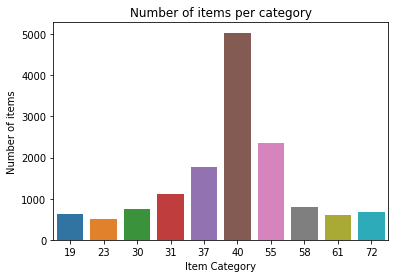

In [11]:
# Print bar plot of the number of items per category
sns.barplot(items_per_category.index, items_per_category.values)
plt.xlabel("Item Category")
plt.ylabel("Number of items")
plt.title("Number of items per category")

What we get from this:

Item category 40 is the one with the highest number of items.

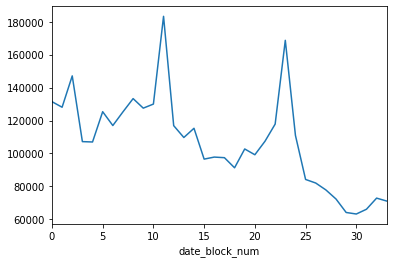

In [12]:
# Analysis of the sales per month
sale_by_month = train.groupby('date_block_num')['item_cnt_day'].sum()
sale_by_month.plot()

What we get from this:

We observe a decreasing trend of sales over the course of the 34 months.

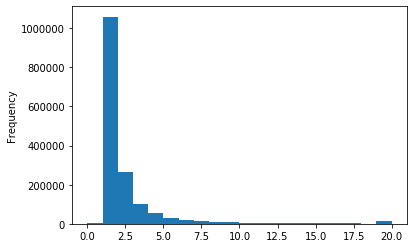

In [13]:
# Analysis of sales grouped by month, item and shop
block_item_shop_sale = train.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum()
block_item_shop_sale.clip(0,20).plot.hist(bins=20)

What we get from this:

The distribution of sale grouped by month, item and shop, we see most item-shop pairs have small monthly sale.

In [14]:
# Analysis of popular shops based on item count in the last 33 months
popular_shops = train.groupby('shop_id')['item_cnt_day'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Popular shops')

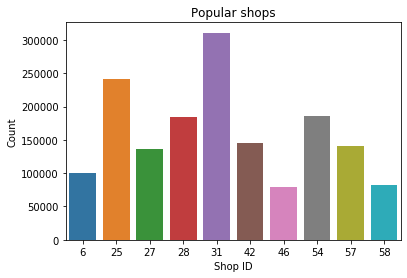

In [15]:
sns.barplot(popular_shops.index, popular_shops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

What we get from this:

The most popular shop is the shop ID 34.

In [16]:
# Analysis of popular items based on item count in the last 33 months
popular_items = train.groupby('item_id')['item_cnt_day'].sum()
popular_items = popular_items.sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Popular items')

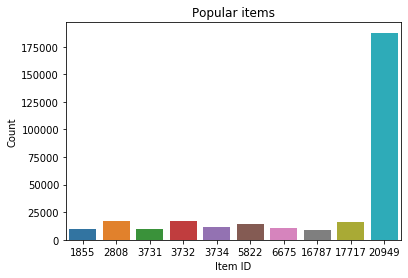

In [17]:
sns.barplot(popular_items.index, popular_items.values)
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.title("Popular items")

What we get from this:

Item"20949" is the item that was sold the most number of items in the last 33 months.

In [18]:
# Analysis of items sold per month
item_cnt_month = train.groupby('date_block_num')['item_cnt_day'].sum()

Text(0.5, 1.0, 'Number of items sold in each month')

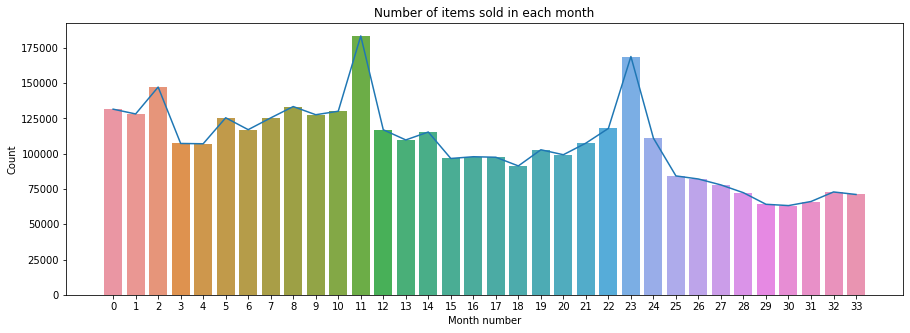

In [19]:
plt.figure(figsize=(15,5))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

What we get from this:

The number of items sold are decreasing over time.
The highest number of items are sold in 11th month.

In [20]:
# Analysis of total price of items sold in each month
price_cnt_month = train.groupby('date_block_num')['item_price'].sum()

Text(0.5, 1.0, 'Total price of items sold in each month')

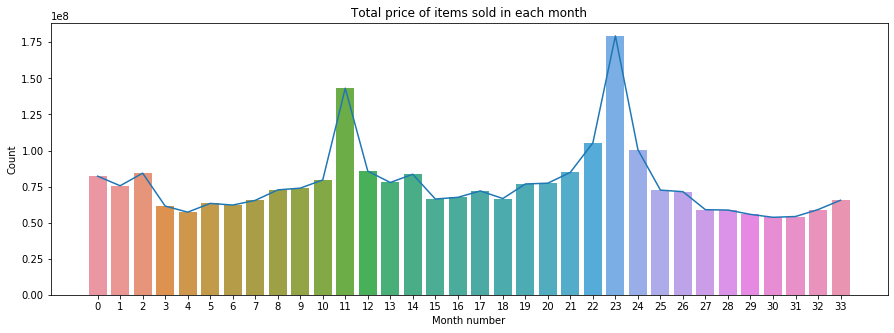

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

What we get from this:

Total price of items sold peaked in Month 11 and 23, probably Christmas season.

In [22]:
# Analysis of the Correlation between "Number of items sold" and "Total price of all items" in each month
np.corrcoef(item_cnt_month.values, price_cnt_month.values)

array([[1.        , 0.73469191],
       [0.73469191, 1.        ]])

What we get from this:

The correlation is 0.735, there is a clear correlation between the number of items sold and the total price of all items, meaning the sales increase outperforms the average price reduction of increased sales volune.


## Pre-Processing & Feature Engineering

In [23]:
# Adding date_block_num 34 to the test data
test_block = train['date_block_num'].max() + 1
test_data['date_block_num'] = test_block
test_data.head()

shop_id  item_id  date_block_num
ID                                  
0         5     5037              34
1         5     5320              34
2         5     5233              34
3         5     5232              34
4         5     5268              34

In [24]:
# Create a grid from all shops/ items combinations per month
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = pd.concat([grid, test_data])

In [25]:
grid.head()

shop_id  item_id  date_block_num
0       59    22154               0
1       59     2552               0
2       59     2554               0
3       59     2555               0
4       59     2564               0

In [26]:
## Create features by grouping shops, items and month
# Groupby data to get shop-item-month aggregates
gb = train.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [27]:
all_data.head()

shop_id  item_id  date_block_num  target  target_shop  target_item
0       59    22154               0     1.0       2017.0         18.0
1       59     2552               0     0.0       2017.0          0.0
2       59     2554               0     0.0       2017.0          1.0
3       59     2555               0     0.0       2017.0          2.0
4       59     2564               0     0.0       2017.0          5.0

In [28]:
## Create features using previous months data - different lags
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift

In [29]:
all_data.head()

shop_id  item_id  date_block_num  target  target_shop  target_item  \
0       59    22154               0     1.0       2017.0         18.0   
1       59     2552               0     0.0       2017.0          0.0   
2       59     2554               0     0.0       2017.0          1.0   
3       59     2555               0     0.0       2017.0          2.0   
4       59     2564               0     0.0       2017.0          5.0   

   target_lag_1  target_item_lag_1  target_shop_lag_1  target_lag_2  ...  \
0           0.0                0.0                0.0           0.0  ...   
1           0.0                0.0                0.0           0.0  ...   
2           0.0                0.0                0.0           0.0  ...   
3           0.0                0.0                0.0           0.0  ...   
4           0.0                0.0                0.0           0.0  ...   

   target_shop_lag_3  target_lag_4  target_item_lag_4  target_shop_lag_4  \
0                0.0           0.0                0.0                0.0   
1                0.0           0.0                0.0                0.0   
2                0.0           0.0                0.0                0.0   
3                0.0           0.0                0.0                0.0   
4                0.0           0.0                0.0                0.0   

   target_lag_5  target_item_lag_5  target_shop_lag_5  target_lag_12  \
0           0.0                0.0                0.0            0.0   
1           0.0                0.0                0.0            0.0   
2           0.0                0.0                0.0            0.0   
3           0.0                0.0                0.0            0.0   
4           0.0                0.0                0.0            0.0   

   target_item_lag_12  target_shop_lag_12  
0                 0.0                 0.0  
1                 0.0                 0.0  
2                 0.0                 0.0  
3                 0.0                 0.0  
4                 0.0                 0.0  

[5 rows x 24 columns]

In [30]:
## Add "item category id" as a feature
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

gc.collect()

159

In [31]:
# Drop columns not required for training and validation
to_drop_cols

['target_shop', 'target', 'target_item', 'date_block_num']

In [32]:
all_data.head()

shop_id  item_id  date_block_num  target  target_shop  target_item  \
0       54    10297              12     4.0       8198.0         23.0   
1       54    10296              12     3.0       8198.0         17.0   
2       54    10298              12    14.0       8198.0        182.0   
3       54    10300              12     3.0       8198.0         26.0   
4       54    10284              12     1.0       8198.0          3.0   

   target_lag_1  target_item_lag_1  target_shop_lag_1  target_lag_2  ...  \
0           3.0               42.0            10055.0           0.0  ...   
1           0.0               24.0            10055.0           0.0  ...   
2          21.0              369.0            10055.0         119.0  ...   
3           1.0               54.0            10055.0          31.0  ...   
4           0.0                4.0            10055.0           0.0  ...   

   target_lag_4  target_item_lag_4  target_shop_lag_4  target_lag_5  \
0           0.0                0.0                0.0           0.0   
1           0.0                0.0                0.0           0.0   
2           0.0                0.0                0.0           0.0   
3           0.0                0.0                0.0           0.0   
4           0.0                3.0             7827.0           0.0   

   target_item_lag_5  target_shop_lag_5  target_lag_12  target_item_lag_12  \
0                0.0                0.0            0.0                 0.0   
1                0.0                0.0            0.0                 0.0   
2                0.0                0.0            0.0                 0.0   
3                0.0                0.0            0.0                 0.0   
4               10.0             7792.0            0.0                 0.0   

   target_shop_lag_12  item_category_id  
0                 0.0                37  
1                 0.0                38  
2                 0.0                40  
3                 0.0                37  
4                 0.0                57  

[5 rows x 25 columns]

### Split data - Train and Test

In [33]:
dates = all_data['date_block_num']

dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

In [34]:
X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

In [35]:
X_train.head()

shop_id  item_id  target_lag_1  target_item_lag_1  target_shop_lag_1  \
0       54    10297           3.0               42.0            10055.0   
1       54    10296           0.0               24.0            10055.0   
2       54    10298          21.0              369.0            10055.0   
3       54    10300           1.0               54.0            10055.0   
4       54    10284           0.0                4.0            10055.0   

   target_lag_2  target_item_lag_2  target_shop_lag_2  target_lag_3  \
0           0.0                2.0             7978.0           0.0   
1           0.0                0.0                0.0           0.0   
2         119.0             1309.0             7978.0           7.0   
3          31.0              361.0             7978.0           0.0   
4           0.0                3.0             7978.0           0.0   

   target_item_lag_3  ...  target_lag_4  target_item_lag_4  target_shop_lag_4  \
0                0.0  ...           0.0                0.0                0.0   
1                0.0  ...           0.0                0.0                0.0   
2              144.0  ...           0.0                0.0                0.0   
3               53.0  ...           0.0                0.0                0.0   
4                5.0  ...           0.0                3.0             7827.0   

   target_lag_5  target_item_lag_5  target_shop_lag_5  target_lag_12  \
0           0.0                0.0                0.0            0.0   
1           0.0                0.0                0.0            0.0   
2           0.0                0.0                0.0            0.0   
3           0.0                0.0                0.0            0.0   
4           0.0               10.0             7792.0            0.0   

   target_item_lag_12  target_shop_lag_12  item_category_id  
0                 0.0                 0.0                37  
1                 0.0                 0.0                38  
2                 0.0                 0.0                40  
3                 0.0                 0.0                37  
4                 0.0                 0.0                57  

[5 rows x 21 columns]

In [36]:
y_train

array([ 4.,  3., 14., ...,  0.,  0.,  0.], dtype=float32)

### Target range - Clip it to [0, 20]

In [37]:
target_range = [0, 20]
target_range

[0, 20]

## Modelling

### Linear Regression

In [38]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

In [39]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lr})
submission.to_csv('Predictions/submission_linear_regression.csv', index=False)

In [40]:
submission.head()

ID  item_cnt_month
0   0        0.595136
1   1        0.101658
2   2        0.955156
3   3        0.234573
4   4        0.118508

### LightGBM

In [41]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)

In [42]:
pkl_filename = "Models/lgb_classifier.pkl"  
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [43]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission.to_csv('Predictions/submission_lgb.csv', index=False)

In [44]:
submission.head()

ID  item_cnt_month
0   0        0.456435
1   1        0.178760
2   2        0.835595
3   3        0.327926
4   4        2.201858

### Concatenate test predictions to get test meta -features

In [45]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

In [46]:
X_test_level2

array([[0.59513646, 0.45643478],
       [0.10165797, 0.17876025],
       [0.95515631, 0.83559476],
       ...,
       [0.08131603, 0.0456353 ],
       [0.1054668 , 0.04369351],
       [0.09177211, 0.04369351]])

### Validation - Second level

### Train meta-features

In [47]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

* KFold scheme in time series
In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.

* Split the train data into chunks of duration T. 
Select first M chunks. Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. 

* Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

In [48]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr.clip(*target_range)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb.clip(*target_range)

27
28
29
30
31
32
33


### Correlation between predictions of different methods

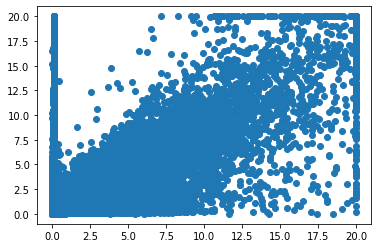

In [49]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

### Ensembling - Simple averaging

- (alpha) * linear_regression + (1-alpha) * lightgbm

In [50]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = []
for alpha in alphas_to_try:
    mix = alpha*X_train_level2[:,0] + (1-alpha)*X_train_level2[:,1]
    r2_scores.append(r2_score(y_train_level2, mix))

r2_scores = np.array(r2_scores)

best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.045000; Corresponding r2 score on train: 0.083548


In [51]:
pred_simple_averaging = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_simple_averaging})
submission.to_csv('Predictions/submission_simple_averaging.csv', index=False)

### Ensembling - Stacking

- Train second level data

In [52]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
pred_stacking = lr.predict(X_test_level2).clip(*target_range)

In [54]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_stacking})
submission.to_csv('Predictions/submission_stacking.csv', index=False)

In [55]:
pred_stacking

array([0.64636206, 0.10313554, 1.26659477, ..., 0.        , 0.        ,
       0.        ])

#### Conclusion

Simple averaging worked better than Stacking.